In [2]:
# 自动计算cell的计算时间
%load_ext autotime

%matplotlib inline
%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

time: 522 ms (started: 2021-08-26 17:56:42 +08:00)


In [ ]:
%%bash

# 增加更新
git add *.ipynb *.md

git remote -v

git commit -m '更新 #7  Aug 26, 2021'

#git push origin master
git push

In [3]:
#设置使用的gpu
import tensorflow as tf
from tensorflow import keras

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU")

time: 4.2 s (started: 2021-08-26 17:57:00 +08:00)


# 设置

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

time: 753 µs (started: 2021-08-26 17:57:22 +08:00)


# 介绍

**迁移学习**包括获取在一个问题上学习的特征，并将它们用于一个新的类似问题。 例如，已经学会识别浣熊的模型的特征可能有助于启动旨在识别狸的模型。

迁移学习通常用于数据集数据太少而无法从头开始训练全尺寸模型的任务。

在深度学习的背景下，迁移学习最常见的化身是以下工作流程：
* 从先前训练的模型中获取层。
* 冻结它们，以避免在未来的训练回合中破坏它们包含的任何信息。
* 在冻结层的顶部添加一些新的、可训练的层。 他们将学习将旧特征转化为对新数据集的预测。
* 在数据集上训练新层。

最后一个可选步骤是微调，包括解冻您在上面获得的整个模型（或其中的一部分），并以非常低的学习率在新数据上重新训练它。 通过逐步使预训练的特征适应新数据，这可能会实现有意义的改进。

首先，我们将详细介绍 Keras 可训练 API，它是大多数迁移学习和微调工作流程的基础。

然后，我们将通过采用在 ImageNet 数据集上预训练的模型，并在 Kaggle “猫 vs 狗”分类数据集上重新训练它来演示典型的工作流程。

这改编自 Deep Learning with Python 和 2016 年的博客文章“使用很少的数据构建强大的图像分类模型”。

# 冻结层：了解可训练属性

层和模型具有三个权重属性：
* `weights` 是层的所有权重变量的列表。
* `trainable_weights` 是那些旨在更新（通过梯度下降）以最小化训练过程中损失的列表。
* `non_trainable_weights` 是那些不需要训练的列表。 通常，它们在前向传递期间由模型更新。

## 示例：密集层有 2 个可训练的权重（内核和偏差）

In [5]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0
time: 1.71 s (started: 2021-08-26 18:00:13 +08:00)


一般来说，所有的权重都是可训练的权重。 唯一具有不可训练权重的内置层是 `BatchNormalization` 层。 它使用不可训练的权重来跟踪训练期间输入的均值和方差。 要了解如何在您自己的自定义层中使用不可训练的权重，请参阅从头开始编写新层的指南。

## 示例：BatchNormalization 层有 2 个可训练的权重和 2 个不可训练的权重

In [6]:
layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 4
trainable_weights: 2
non_trainable_weights: 2
time: 16 ms (started: 2021-08-26 18:01:03 +08:00)


层和模型还具有可训练的布尔属性。 它的值是可以改变的。 将 `layer.trainable` 设置为 False 会将所有层的权重从可训练移动到不可训练。 这称为“冻结”层：在训练期间（使用 fit() 进行训练或使用任何依赖 `trainable_weights` 应用梯度更新的自定义循环进行训练时）不会更新冻结层的状态。

## 示例：将 trainable 设置为 False

In [7]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2
time: 18.1 ms (started: 2021-08-26 18:01:53 +08:00)


当可训练权重变为不可训练时，其值在训练期间不再更新。

In [8]:
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# 保留一份 layer1 的权重副本供以后参考
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)

1/1 [==============================] - 3s 3s/step - loss: 0.0792
time: 3.76 s (started: 2021-08-26 18:02:48 +08:00)


不要将 `layer.trainable` 属性与 `layer.__call__()` 中的参数 `training` 混淆（它控制该层是否应该在推理模式或训练模式下运行其前向传递）。 有关更多信息，请参阅 Keras 常见问题解答。

# 可训练属性的递归设置

如果您在模型或任何具有子层的层上设置 trainable = False，则所有子层也将变为不可训练。

例子：

In [10]:
inner_model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(3,)),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(3, activation="relu"),
    ]
)

model = keras.Sequential(
    [keras.layers.InputLayer(input_shape=(3,)), inner_model, keras.layers.Dense(3, activation="sigmoid"),]
)

model.trainable = False  # Freeze the outer model

assert inner_model.trainable == False  # All layers in `model` are now frozen
assert inner_model.layers[0].trainable == False  # `trainable` is propagated recursively

time: 61.8 ms (started: 2021-08-26 18:06:15 +08:00)


# 典型的迁移学习工作流程

这引导我们了解如何在 Keras 中实现典型的迁移学习工作流程：
1. 实例化一个基本模型并将预训练的权重加载到其中。
2. 通过设置`trainable = False`来冻结基础模型中的所有层。
3. 在基础模型的一个（或多个）层的输出之上创建一个新模型。
4. 在新数据集上训练新模型。

请注意，另一种更轻量级的工作流程也可以是：
1. 实例化一个基本模型并将预训练的权重加载到其中。
2. 通过它运行您的新数据集并记录来自基础模型的一个（或多个）层的输出。 这称为特征提取。
3. 将该输出用作新的较小模型的输入数据。

第二个工作流程的一个关键优势是您只对数据运行一次基本模型，而不是每个训练时期运行一次。 所以它更快更便宜。

但是，第二个工作流程的一个问题是它不允许您在训练期间动态修改新模型的输入数据，例如在进行数据增强时需要这样做。 当新数据集的数据太少而无法从头开始训练全尺寸模型时，迁移学习通常用于任务，在这种情况下，数据增强非常重要。 因此，在接下来的内容中，我们将专注于第一个工作流程。

这是 Keras 中第一个工作流程的样子：

首先，使用预训练的权重实例化一个基本模型。

In [11]:
base_model = keras.applications.Xception(
    weights='imagenet',  # 加载在 ImageNet 上预训练的权重。
    input_shape=(150, 150, 3),
    include_top=False)  # 不要在顶部包含 ImageNet 分类器。

time: 5.79 s (started: 2021-08-26 18:08:39 +08:00)


然后，冻结基础模型。

In [12]:
base_model.trainable = False

time: 10.1 ms (started: 2021-08-26 18:09:00 +08:00)


在顶部创建一个新模型。

In [13]:
inputs = keras.Input(shape=(150, 150, 3))

# 我们通过传递`training=False`来确保base_model在这里以推理模式运行。 这对于微调很重要，您将在几段中了解到。
x = base_model(inputs, training=False)

# 将形状“base_model.output_shape[1:]”的特征转换为向量
x = keras.layers.GlobalAveragePooling2D()(x)

# 具有单个单元的密集分类器（二元分类）
outputs = keras.layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

time: 471 ms (started: 2021-08-26 18:11:11 +08:00)


在新数据上训练模型。

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)

# 微调

一旦您的模型在新数据上收敛，您就可以尝试解冻全部或部分基础模型，并以非常低的学习率重新训练整个模型。

这是可选的最后一步，可以潜在地为您提供增量改进。它也可能导致快速过度拟合——请记住这一点。

只有在具有冻结层的模型经过训练收敛后才执行此步骤至关重要。如果将随机初始化的可训练层与包含预训练特征的可训练层混合使用，则随机初始化的层将在训练期间导致非常大的梯度更新，这会破坏您的预训练特征。

在此阶段使用非常低的学习率也很重要，因为您正在训练比第一轮训练大得多的模型，而且数据集通常非常小。因此，如果您应用大量的权重更新，您将面临很快过度拟合的风险。在这里，您只想以增量方式重新调整预训练的权重。

这是如何实现整个基础模型的微调：

In [ ]:
# 解冻基础模型
base_model.trainable = True

# 在对任何内层的 `trainable` 属性进行任何更改后重新编译模型很重要，以便您的更改被考虑在内
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# 端到端的训练。 小心在你过拟合之前停下来！
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)

## 关于 `compile()` 和 `trainable` 的重要说明

在模型上调用 `compile()` 旨在“冻结”该模型的行为。 这意味着编译模型时的可训练属性值应在该模型的整个生命周期中保留，直到再次调用 `compile`。 因此，如果您更改任何可训练的值，请确保在您的模型上再次调用 `compile()` 以考虑您的更改。

## 关于 `BatchNormalization` 层的重要说明

许多图像模型包含 `BatchNormalization` 层。该层是每个可以想象的计数的特例。这里有一些注意事项。
* `BatchNormalization` 包含 2 个不可训练的权重，在训练期间会更新。这些是跟踪输入均值和方差的变量。
* 当您设置 `bn_layer.trainable = False` 时，`BatchNormalization` 层将以推理模式运行，并且不会更新其均值和方差统计信息。通常其他层的情况并非如此，因为权重可训练性和推理/训练模式是两个正交概念。但是在 `BatchNormalization` 层的情况下，两者是联系在一起的。
* 当您解冻包含 `BatchNormalization` 层的模型以进行微调时，您应该通过在调用基本模型时传递 `training=False` 来将 `BatchNormalization` 层保持在推理模式。否则，应用于不可训练权重的更新会突然破坏模型所学到的东西。

您将在本指南末尾的端到端示例中看到此模式的实际应用。

# 使用自定义训练循环进行迁移学习和微调
如果您使用自己的低级训练循环而不是 `fit()`，则工作流程基本保持不变。 在应用梯度更新时，您应该小心只考虑列表 `model.trainable_weights`：

In [ ]:
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

# Create new model on top.
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()

# Iterate over the batches of a dataset.
for inputs, targets in new_dataset:
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        predictions = model(inputs)
        # Compute the loss value for this batch.
        loss_value = loss_fn(targets, predictions)

    # Get gradients of loss wrt the *trainable* weights.
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

同样用于微调。

# 端到端示例：在猫与狗数据集上微调图像分类模型
为了巩固这些概念，让我们带您了解一个具体的端到端迁移学习和微调示例。 我们将加载在 ImageNet 上预先训练的 Xception 模型，并将其用于 Kaggle“猫与狗”分类数据集。

## 获取数据
首先，让我们使用 TFDS 获取猫与狗的数据集。 如果您有自己的数据集，您可能希望使用实用程序 `tf.keras.preprocessing.image_dataset_from_directory` 从磁盘上归档到特定于类的文件夹中的一组图像生成类似的标记数据集对象。

迁移学习在处理非常小的数据集时最有用。 为了保持我们的数据集较小，我们将使用 40% 的原始训练数据（25,000 张图像）进行训练，10% 用于验证，10% 用于测试。

In [16]:
import tensorflow_datasets as tfds

# tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Dataset cats_vs_dogs downloaded and prepared to /home/huangwei/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326
time: 9min 49s (started: 2021-08-26 18:21:41 +08:00)


这些是训练数据集中的前 9 张图像——如您所见，它们的大小各不相同。

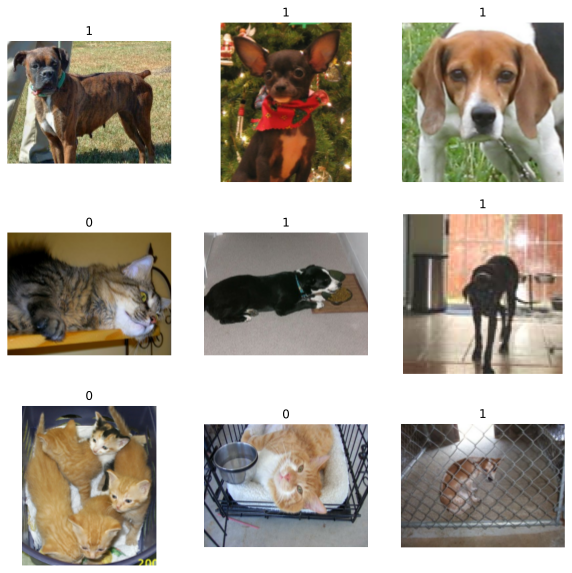

time: 928 ms (started: 2021-08-26 18:31:31 +08:00)


In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

我们还可以看到标签 1 是“狗”，标签 0 是“猫”。

## 标准化数据

我们的原始图像有多种尺寸。 此外，每个像素由 0 到 255（RGB 级别值）之间的 3 个整数值组成。 这不太适合馈送神经网络。 我们需要做两件事：
* 标准化为固定的图像大小。 我们选择 150x150。
* 标准化介于 -1 和 1 之间的像素值。我们将使用标准化层作为模型本身的一部分来执行此操作。

一般来说，开发将原始数据作为输入的模型是一种很好的做法，而不是采用已经预处理过的数据的模型。 原因是，如果您的模型需要预处理数据，那么每当您导出模型以在其他地方（在 Web 浏览器中、在移动应用程序中）使用它时，您都需要重新实现完全相同的预处理管道。 这很快就会变得非常棘手。 所以我们应该在击中模型之前做尽可能少的预处理。

在这里，我们将在数据管道中调整图像大小（因为深度神经网络只能处理连续批次的数据），并且我们将在创建模型时将输入值缩放作为模型的一部分。

让我们将图像大小调整为 150x150：

In [19]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

time: 104 ms (started: 2021-08-26 18:31:32 +08:00)


此外，让我们批量处理数据并使用缓存和预取来优化加载速度。

In [20]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

time: 3.78 ms (started: 2021-08-26 18:31:32 +08:00)


## 使用随机数据增强
当您没有大型图像数据集时，通过对训练图像应用随机但真实的变换（例如随机水平翻转或小的随机旋转）来人为地引入样本多样性是一种很好的做法。 这有助于将模型暴露于训练数据的不同方面，同时减缓过度拟合。

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

time: 29.6 ms (started: 2021-08-26 18:31:33 +08:00)


让我们想象一下经过各种随机变换后第一批的第一张图像的样子：

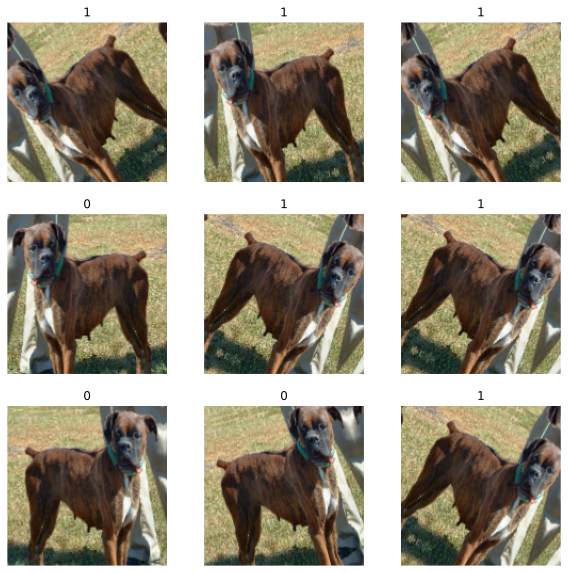

time: 1.21 s (started: 2021-08-26 18:31:50 +08:00)


In [23]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

# 建立模型
现在让我们按照我们之前解释的蓝图构建一个模型。

注意：

我们添加了一个标准化层来将输入值（最初在 [0, 255] 范围内）缩放到 [-1, 1] 范围内。
我们在分类层之前添加了一个`Dropout` 层，用于正则化。
我们确保在调用基本模型时传递 `training=False`，以便它在推理模式下运行，这样即使在我们解冻基本模型进行微调之后，`batchnorm`统计信息也不会更新。

In [24]:
base_model = keras.applications.Xception(
    weights="imagenet",  # 加载在 ImageNet 上预训练的权重。
    input_shape=(150, 150, 3),
    include_top=False,
)  # 不要在顶部包含 ImageNet 分类器。

# 冻结 base_model
base_model.trainable = False

# 在顶部创建新模型
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# 预训练的 Xception 权重要求将输入从 (0, 255) 归一化到范围 (-1., +1.)，
# 归一化层执行以下操作，输出 = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# 基础模型包含batchnorm 层。 当我们解冻基本模型进行微调时，
# 我们希望将它们保持在推理模式，因此我们确保 base_model 在此处以推理模式运行。
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 2049

# 训练顶层

In [25]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 36s 85ms/step - loss: 0.1635 - binary_accuracy: 0.9310 - val_loss: 0.0812 - val_binary_accuracy: 0.9708
Epoch 2/20
291/291 [==============================] - 19s 66ms/step - loss: 0.1180 - binary_accuracy: 0.9507 - val_loss: 0.0780 - val_binary_accuracy: 0.9699
Epoch 3/20
291/291 [==============================] - 19s 64ms/step - loss: 0.1078 - binary_accuracy: 0.9535 - val_loss: 0.0768 - val_binary_accuracy: 0.9678
Epoch 4/20
291/291 [==============================] - 18s 62ms/step - loss: 0.1047 - binary_accuracy: 0.9563 - val_loss: 0.0707 - val_binary_accuracy: 0.9716
Epoch 5/20
291/291 [==============================] - 18s 62ms/step - loss: 0.1034 - binary_accuracy: 0.9597 - val_loss: 0.0726 - val_binary_accuracy: 0.9712
Epoch 6/20
291/291 [==============================] - 18s 62ms/step - loss: 0.0998 - binary_accuracy: 0.9572 - val_loss: 0.0720 - val_binary_accuracy: 0.9733
Epoch 7/20
291/291 [==============================] 

time: 6min 43s (started: 2021-08-26 18:33:15 +08:00)


# 对整个模型做一轮微调
最后，让我们解冻基础模型，并以低学习率端到端地训练整个模型。

重要的是，尽管基础模型变得可训练，但它仍在推理模式下运行，因为我们在构建模型时调用它时传递了 training=False。 这意味着里面的批标准化层不会更新它们的批统计信息。 如果他们这样做了，他们将破坏迄今为止模型学习的表示。

In [26]:
# 解冻 base_model。 请注意，由于我们在调用它时传递了“training=False”，因此它一直在推理模式下运行。 
# 这意味着 batchnorm 层不会更新它们的批次统计信息。 这可以防止 batchnorm 层撤销我们迄今为止所做的所有训练。
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 2049

time: 9min (started: 2021-08-26 18:39:58 +08:00)


在 10 个 epoch 之后，微调在这里获得了很好的改进。